In [1]:
# Problem: When collateral = 0 (i.e. there is bad debt) ltv = inf
# -> Changed it so when collateral = 0, ltv = NaN
# ltv = NaN now identifies bad debt

# TODO: Positions can be "revived" - if collateral goes to 0, a large enough random supply can bring it back to ok ltv

# TODO: Set smallest currency unit, don't allow positions smaller than that

# TODO: Set correct behaviour with liquidation_bonus and liquidation_threshold;
    # Currently bonus and threshold set as constant 
    # Maybe: take from market_state if defined as None, otherwise use defined constant

# TODO: Truncate initial LTV values at ltv_threshold and skip first round of liquidations?

# TODO: Change table format to include data after liquidation at same block as additional columns? - Maybe as amount liquidated rather than absolute values?

# TODO: Batch data before writing to parquet

In [2]:
# from pathlib import Path
from tqdm import tqdm # progress bar for loop
import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa # to store data as parquet
import pyarrow.parquet as pq # to store data as parquet
from matplotlib import pyplot as plt
from my_functions import create_token_df
from market_env.constants import DATA_PATH, FIGURE_PATH

In [3]:
# Liquidation parameters
supply_token = "WBTC" # supply token
debt_token = "USDC" # debt token
closing_factor = 0.5
liquidation_bonus = 0.045  # (reserveLiquidationBonus - 1) in market_state, but treated as constant
liquidation_threshold = 0.78 # reserveLiquidationThreshold in market state, but treated as constant

# Initial LTV distribution parameters - how to best determine these?
n =     10_000 # Number of simulated users
mu =    0.5
sigma = 0.15

# User transaction parameters
participation_proportion = 0.1 # proportion of users that participate in user initiated transactions at each block

In [4]:
toxicity_condition = 1/(1+liquidation_bonus)  
toxicity_condition

0.9569377990430623

# Pool Data

In [5]:
# Time series of aggregate positions
df_supply_token = create_token_df(DATA_PATH/"aave_parquet", supply_token)
df_debt_token = create_token_df(DATA_PATH/"aave_parquet", debt_token)

market_state = pd.DataFrame({
    'block_number':             df_supply_token['blockNumber'],
    'borrowed_tokens':          df_debt_token['actualDebt'],
    'supplied_tokens':          df_supply_token['actualSupplied'],
    'debt_token_price':         df_debt_token['priceInMarketReferenceCurrency'],
    'supply_token_price':       df_supply_token['priceInMarketReferenceCurrency'],
    'borrowed_usd':             df_debt_token['actualDebt'] * df_debt_token['priceInMarketReferenceCurrency'],
    'supplied_usd':             df_supply_token['actualSupplied'] * df_supply_token['priceInMarketReferenceCurrency'],
    'liquidation_bonus':        df_debt_token['reserveLiquidationBonus'] - 1,
    'liquidation_threshold':    df_debt_token['reserveLiquidationThreshold'],
    })

#market_state = market_state.set_index('block_number')

market_state['utilisation'] = market_state['borrowed_usd'] / market_state['supplied_usd']


# TODO: Many blocks have no changes from the previous
# Maybe: don't use blocknumber as index, remove all blocks with no changes and then reset index, 
# This way I can iterate through index and skip the gaps with no changes 

mask = (
    (market_state["supplied_tokens"].diff() != 0) |
    (market_state["borrowed_tokens"].diff() != 0) |
    (market_state["supply_token_price"].diff() != 0) |
    (market_state["debt_token_price"].diff() != 0)
)

market_state = market_state[mask].reset_index(drop=True)

market_state

,block_number,borrowed_tokens,supplied_tokens,debt_token_price,supply_token_price,borrowed_usd,supplied_usd,liquidation_bonus,liquidation_threshold,utilisation
0,20921766,1.343552e+09,37032.574981,0.999900,62373.304441,1.343418e+09,2.309844e+09,0.045,0.78,0.581605
1,20921774,1.343552e+09,37032.574981,0.999900,62033.955787,1.343418e+09,2.297277e+09,0.045,0.78,0.584787
2,20921791,1.343548e+09,37032.574981,0.999900,62033.955787,1.343414e+09,2.297277e+09,0.045,0.78,0.584785
3,20921804,1.343548e+09,37035.904643,0.999900,62033.955787,1.343414e+09,2.297484e+09,0.045,0.78,0.584733
4,20921807,1.343548e+09,37036.812609,0.999900,62033.955787,1.343414e+09,2.297540e+09,0.045,0.78,0.584718
...,...,...,...,...,...,...,...,...,...,...
427629,23330980,4.949374e+09,45711.376875,0.999763,111609.479848,4.948200e+09,5.101823e+09,0.045,0.78,0.969889
427630,23330981,4.949375e+09,45711.376875,0.999763,111609.479848,4.948202e+09,5.101823e+09,0.045,0.78,0.969889
427631,23330986,4.949375e+09,45711.421545,0.999763,111609.479848,4.948202e+09,5.101828e+09,0.045,0.78,0.969888
427632,23331003,4.949386e+09,45711.421545,0.999763,111609.479848,4.948213e+09,5.101828e+09,0.045,0.78,0.969890


# Initialising User Positions

Simulate n LTVs from normal distribution  
Calculate each of the n user's position such that:  
The individual user's usd supplies & borrows result in the given LTV  
AND  
Total usd supplies and borrows of all users match the market data at the first block

In [6]:
t = 0 # To get inital block data
current_block_number = market_state.loc[t, "block_number"]
current_block_number

np.int64(20921766)

In [7]:
# Generate initial LTV distribution of users
user_ltvs = np.random.lognormal(np.log(mu), sigma, n) # Array of n LTVs following the given distribution

# Clip values so there are no negative LTVs or LTVs initiating a liquidation loop
user_ltvs = np.clip(user_ltvs, 0, liquidation_threshold) 

In [8]:
# Construct user positions from LTVs, given total supplies and debts
def allocate_by_linear_LTV(user_ltvs, total_supplies, total_debts):
    """
    user_ltvs : array-like of LTVs (length n)
    total_supplies, total_debts : scalars (pool totals)
    Returns DataFrame with columns LTV, Supply, Debt
    """
    user_ltvs = np.asarray(user_ltvs, dtype=float)
    n = user_ltvs.size
    sum_LTVs = user_ltvs.sum()
    sum_LTVs2 = (user_ltvs**2).sum()

    A = np.array([[n,        sum_LTVs],
                  [sum_LTVs, sum_LTVs2]], dtype=float)
    b = np.array([total_supplies, total_debts], dtype=float)

    # Solve for a, b
    a, b_coef = np.linalg.solve(A, b)

    user_supplies = a + b_coef * user_ltvs
    user_debts = user_ltvs * user_supplies

    df = pd.DataFrame({
        "borrowed": user_debts,
        "supplied": user_supplies,
        "initial_ltv": user_ltvs
    })

    df[["supplied", "borrowed"]] = df[["supplied", "borrowed"]].abs()

    # floating point round-off may make sums a tiny bit different
    df["supplied"] *= total_supplies / df["supplied"].sum()
    df["borrowed"] = df["initial_ltv"] * df["supplied"]
    df["ltv"] = df["borrowed"]/df["supplied"]

    return df, (a, b_coef)


In [ ]:
# Initialise user_positions df for the first block

# Distribute total supplies and debts, given LTVs
initial_supplied_usd = market_state['supplied_usd'].iloc[0]
initial_borrowed_usd = market_state['borrowed_usd'].iloc[0]
initial_user_positions, _ = allocate_by_linear_LTV(user_ltvs, initial_supplied_usd, initial_borrowed_usd)

initial_user_positions = pd.DataFrame({
    'block_number':     current_block_number,
    'id':                   range(0,n),
    'borrowed_tokens':  initial_user_positions['borrowed']/market_state['debt_token_price'].iloc[0],
    'supplied_tokens':  initial_user_positions['supplied']/market_state['supply_token_price'].iloc[0],
    'borrowed_usd':     initial_user_positions['borrowed'],
    'supplied_usd':     initial_user_positions['supplied'],
    'ltv':              initial_user_positions['ltv']
})


initial_user_positions


,block_number,id,borrowed_tokens,supplied_tokens,borrowed_usd,supplied_usd,ltv
0,20921766,0,460486.481309,10.857171,460440.432661,677197.604405,0.679920
1,20921766,1,6520.408811,0.239956,6519.756770,14966.819052,0.435614
2,20921766,2,15506.274554,0.561122,15504.723926,34999.042815,0.443004
3,20921766,3,941.173922,0.035147,941.079805,2192.208735,0.429284
4,20921766,4,128933.335733,3.964752,128920.442399,247294.706548,0.521323
...,...,...,...,...,...,...,...
9995,20921766,9995,137924.927838,4.198024,137911.135345,261844.606907,0.526691
9996,20921766,9996,55063.674575,1.866089,55058.168208,116394.163275,0.473032
9997,20921766,9997,60817.709522,2.639648,60811.627751,164643.539537,0.369353
9998,20921766,9998,142478.521989,4.314639,142464.274137,269118.313303,0.529374


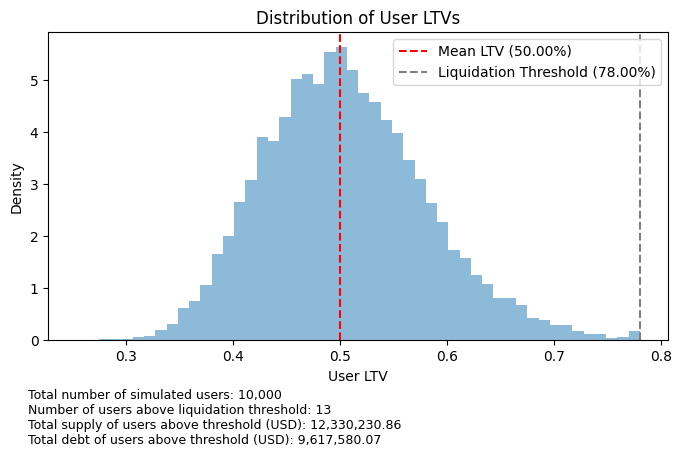

In [10]:
# Plot initial user LTV distribution
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(initial_user_positions['ltv'], bins=50, alpha=0.5, density=True)
ax.axvline(mu, color='red', linestyle='--', label=f'Mean LTV ({mu*100:.2f}%)')
ax.axvline(liquidation_threshold, color='grey', linestyle='--', label=f'Liquidation Threshold ({liquidation_threshold*100:.2f}%)')
ax.set_xlabel('User LTV')
ax.set_ylabel('Density')
ax.set_title('Distribution of User LTVs')
ax.legend()

# --- Compute stats ---
users_above_threshold = initial_user_positions[initial_user_positions['ltv'] >= liquidation_threshold]
num_users = users_above_threshold['ltv'].count()
total_supply = users_above_threshold["supplied_usd"].sum()
total_debt = users_above_threshold["borrowed_usd"].sum()

# --- Add text below plot (figure coordinates) ---
fig.text(
    0.1, -0.15,  # x, y in figure coordinates (y<0 moves it below the axes)
f"Total number of simulated users: {n:,}\n\
Number of users above liquidation threshold: {num_users}\n\
Total supply of users above threshold (USD): {total_supply:,.2f}\n\
Total debt of users above threshold (USD): {total_debt:,.2f}",
    fontsize=9
)

# --- Save figure ---

plt.savefig(FIGURE_PATH/"user_ltv_distribution.pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

# First round of liquidations 
updates usd amounts, token amounts follow from this

In [11]:
def execute_liquidations(
    block_number,
    current_user_positions_df,
    market_states_df=market_state,
    closing_factor=closing_factor,
    liquidation_bonus=liquidation_bonus,
):
    """
    Execute liquidations on a user_positions dataframe for a given block. 
    Returns that block's dataframe after liquidations
    
    user_positions_df must contain columns: 'block_number', 'debt', 'supply', 'ltv'.

    market_states_df must contain columns: 'block_number', 'debt_token_price', 'supply_token_price'
    
    """

    # Copy user positions on current block
    liquidation_df = current_user_positions_df.copy()

    # Identify undercollateralised positions
    mask = liquidation_df["ltv"] >= liquidation_threshold

    # Constraints on amount of debt that can be liquidated: min(c * debt, supply / (1 + i))
    debt_cap = closing_factor * liquidation_df["borrowed_usd"]
    supply_cap = liquidation_df["supplied_usd"] / (1 + liquidation_bonus)

    # Create vector of amounts of debt liquidated
    debt_removed = np.minimum(debt_cap, supply_cap)
    debt_removed = debt_removed.where(mask, 0)
    # Corresponding supply removed
    supply_removed = debt_removed * (1 + liquidation_bonus)

    # Update dataframe after liquidations
    liquidation_df["block_number"] = block_number+0.5
    liquidation_df["borrowed_usd"] = liquidation_df["borrowed_usd"] - debt_removed
    liquidation_df["supplied_usd"] = liquidation_df["supplied_usd"] - supply_removed
    liquidation_df["ltv"]          = (
        liquidation_df["borrowed_usd"] / liquidation_df["supplied_usd"]
        ).where(liquidation_df["supplied_usd"] != 0, np.nan)

    liquidation_df["borrowed_tokens"] = liquidation_df["borrowed_usd"]/market_states_df.loc[t, "debt_token_price"]
    liquidation_df["supplied_tokens"] = liquidation_df["supplied_usd"]/market_states_df.loc[t, "supply_token_price"]


    return liquidation_df


In [12]:
def execute_user_transactions(current_block_position_df):
    # Change current block positions by user transactions
    delta_supplied_total = market_state["supplied_tokens"].diff().loc[t]
    delta_supplied_user  = delta_supplied_total / (n * participation_proportion)
    delta_borrowed_total = market_state["borrowed_tokens"].diff().loc[t]
    delta_borrowed_user = delta_borrowed_total / (n * participation_proportion)

    # Prices & thresholds
    debt_token_price      = market_state.loc[t-1, "debt_token_price"] # old price, not taking price changes into account yet
    supply_token_price    = market_state.loc[t-1, "supply_token_price"] # old price, not taking price changes into account yet

    # If there was a change in supplied tokens
    if delta_supplied_total != 0:
        # Apply delta_supplied_user to each user to simulate positions after transaction
        qualified_suppliers = current_block_position_df.copy()
        qualified_suppliers['new_supplied_tokens'] = qualified_suppliers['supplied_tokens'] + delta_supplied_user
        qualified_suppliers['new_supplied_usd']    = qualified_suppliers['new_supplied_tokens'] * supply_token_price
        qualified_suppliers['new_ltv']             = qualified_suppliers['borrowed_usd'] / qualified_suppliers['new_supplied_usd']

        # Select only rows meeting the conditions
        supply_mask = (
            (qualified_suppliers["new_supplied_tokens"] > 0) &  # user must have sufficient balance
            (
                (qualified_suppliers["new_ltv"] < liquidation_threshold) |  # either LTV under threshold
                (qualified_suppliers["new_ltv"] < qualified_suppliers["ltv"])  # or LTV decreases
            )
        )
        qualified_suppliers = qualified_suppliers[supply_mask]
        sampled_supply_users = qualified_suppliers["id"].sample(frac=participation_proportion)

        # increment token amounts by delta_supplied_user
        current_block_position_df.loc[current_block_position_df["id"].isin(sampled_supply_users), "supplied_tokens"] += delta_supplied_user

    # If there was a change in borrowed tokens
    if delta_borrowed_total != 0:
        # Apply delta_borrowed_user to each user to simulate positions after transaction
        qualified_borrowers = current_block_position_df.copy()
        qualified_borrowers["new_borrowed_tokens"] = qualified_borrowers["borrowed_tokens"] + delta_borrowed_user
        qualified_borrowers["new_borrowed_usd"]    = qualified_borrowers["new_borrowed_tokens"] * debt_token_price
        qualified_borrowers["new_ltv"]             = qualified_borrowers["new_borrowed_usd"] / qualified_borrowers["supplied_usd"]

        # Select only rows meeting the conditions
        borrow_mask = (
            (qualified_borrowers["new_borrowed_tokens"] > 0) &  # must have sufficient debt
            (
                (qualified_borrowers["new_ltv"] < liquidation_threshold) |  # either LTV under threshold
                (qualified_borrowers["new_ltv"] < qualified_borrowers["ltv"])  # or LTV decreases
            )
        )
        qualified_borrowers = qualified_borrowers[borrow_mask]
        sampled_borrow_users = qualified_borrowers['id'].sample(frac=participation_proportion)
        
        # increment token amounts by delta_borrowed_user
        current_block_position_df.loc[current_block_position_df["id"].isin(sampled_borrow_users), "borrowed_tokens"] += delta_borrowed_user
    
    return current_block_position_df

def update_positions_with_price(current_block_positions_df):
    # Update usd amounts using new price at time t
    # keep block_number but change usd amounts and resulting ltv
    current_debt_token_price = market_state.loc[t,"debt_token_price"]
    current_supply_token_price = market_state.loc[t,"supply_token_price"]

    current_block_positions_df["borrowed_usd"] = current_block_positions_df["borrowed_tokens"] * current_debt_token_price
    current_block_positions_df["supplied_usd"] = current_block_positions_df["supplied_tokens"] * current_supply_token_price
    current_block_positions_df["ltv"]          = (
        current_block_positions_df["borrowed_usd"] / current_block_positions_df["supplied_usd"]
    ).where(current_block_positions_df['supplied_usd'] != 0, np.nan)

    return current_block_positions_df


In [13]:
current_block_positions_after_liq = execute_liquidations(
    block_number=current_block_number, current_user_positions_df=initial_user_positions
    )
initial_user_positions = pd.concat([initial_user_positions, current_block_positions_after_liq], ignore_index=True)
initial_user_positions


,block_number,id,borrowed_tokens,supplied_tokens,borrowed_usd,supplied_usd,ltv
0,20921766.0,0,460486.481309,10.857171,460440.432661,677197.604405,0.679920
1,20921766.0,1,6520.408811,0.239956,6519.756770,14966.819052,0.435614
2,20921766.0,2,15506.274554,0.561122,15504.723926,34999.042815,0.443004
3,20921766.0,3,941.173922,0.035147,941.079805,2192.208735,0.429284
4,20921766.0,4,128933.335733,3.964752,128920.442399,247294.706548,0.521323
...,...,...,...,...,...,...,...
19995,20921766.5,9995,137924.927838,4.198024,137911.135345,261844.606907,0.526691
19996,20921766.5,9996,55063.674575,1.866089,55058.168208,116394.163275,0.473032
19997,20921766.5,9997,60817.709522,2.639648,60811.627751,164643.539537,0.369353
19998,20921766.5,9998,142478.521989,4.314639,142464.274137,269118.313303,0.529374


# Iterate through blocks

In [14]:
schema = {
    "block_number": "float64",
    "id": "int64",
    "borrowed_tokens":"float64",
    "supplied_tokens":"float64",
    "borrowed_usd":"float64",
    "supplied_usd":"float64",
    "ltv":"float64"
}

writer = None # This is used to stream the data into a parquet file


# Iterate through each time=t, starting from 1
#for t in tqdm(range(1, len(market_state))):
for t in tqdm(range(1, 1_000)): # 7k ca 1 days when using all blocks

    previous_block_number = market_state.loc[t-1, "block_number"]
    current_block_number  = market_state.loc[t,   "block_number"]

    # Current block positions
    current_block_positions = (
        current_block_positions_after_liq
        .copy()
        .reset_index(drop=True)
    )
    current_block_positions["block_number"] = current_block_number

    # Apply user transactions + price update
    current_block_positions = execute_user_transactions(current_block_positions)
    current_block_positions = update_positions_with_price(current_block_positions)
    current_block_positions = current_block_positions.astype(schema)

    # Store block t
    # write first batch
    table1 = pa.Table.from_pandas(current_block_positions, preserve_index=False)
    if writer is None:
        writer = pq.ParquetWriter(DATA_PATH/"liquidation_model_outputs"/"user_positions.parquet", table1.schema)
    writer.write_table(table1)

    # Liquidations
    current_block_positions_after_liq = execute_liquidations(
        block_number=current_block_number,
        current_user_positions_df=current_block_positions
    )

    current_block_positions_after_liq = current_block_positions_after_liq.astype(schema)

    # Store block t + 0.5
    table2 = pa.Table.from_pandas(current_block_positions_after_liq, preserve_index=False)
    writer.write_table(table2)

writer.close()


100%|██████████| 999/999 [00:08<00:00, 120.95it/s]


In [15]:
user_positions = pl.read_parquet(DATA_PATH/"liquidation_model_outputs"/"user_positions.parquet")

In [16]:
all_bad_debt_positions = user_positions.filter(pl.col("ltv").is_null())
unique_bad_debt_ids = (
    all_bad_debt_positions
    .select(pl.col("id"))
    .unique()
    .to_series()
)

print(f"Number of users with bad debt: {len(unique_bad_debt_ids)}")

bad_debt_id_positions = (
    user_positions
    .filter(pl.col("id").is_in(unique_bad_debt_ids.implode()))
    .sort(["id", "block_number"])
)

print("Full time series of each user that has bad debt at any point")
display(bad_debt_id_positions.to_pandas())

Number of users with bad debt: 0
Full time series of each user that has bad debt at any point


,block_number,id,borrowed_tokens,supplied_tokens,borrowed_usd,supplied_usd,ltv


In [17]:
print("Row(s) containing the max ltv")
max_ltv = user_positions.select(pl.max("ltv")).item()
row_max_ltv = user_positions.filter(pl.col("ltv") == max_ltv)
display(row_max_ltv.to_pandas())

Row(s) containing the max ltv


,block_number,id,borrowed_tokens,supplied_tokens,borrowed_usd,supplied_usd,ltv
0,20936830.0,3882,3908.39158,0.083469,3908.229929,4981.251287,0.784588


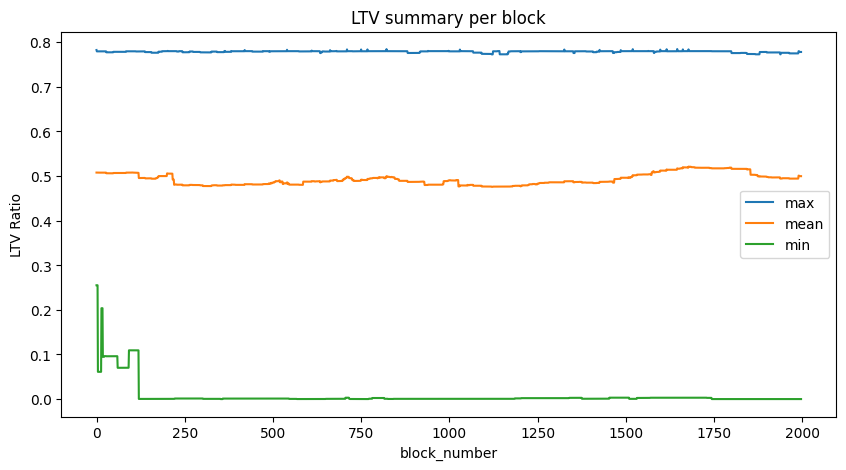

In [18]:
# Plot min, avg, max LTV over period

# Aggregate statistics per block
ltv_plot_df = (
    user_positions
    .group_by("block_number")
    .agg([
        pl.col("ltv").min().alias("ltv_min"),
        pl.col("ltv").mean().alias("ltv_mean"),
        pl.col("ltv").max().alias("ltv_max"),
    ])
    .sort("block_number")
).to_pandas()


plt.figure(figsize=(10,5))

plt.plot(ltv_plot_df["ltv_max"], label="max")
plt.plot(ltv_plot_df["ltv_mean"], label="mean")
plt.plot(ltv_plot_df["ltv_min"], label="min")

plt.xlabel("block_number")
plt.ylabel("LTV Ratio")
plt.title("LTV summary per block")
plt.legend()

plt.savefig(FIGURE_PATH/"ltv_summary_time_series.pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()